## 1. Importing All Necessary Libraries

In this step, we import all the libraries required for our project.  
We use:
- **NumPy** and **Matplotlib** for data handling and visualization.  
- **Scikit-learn** for data preprocessing, model training, and evaluation.  
- **Keras (with NumPy backend)** to load the Fashion-MNIST dataset.  

We also set a random seed to ensure reproducibility of our results.

We use the **Fashion-MNIST** dataset provided by Keras.  
It contains 70,000 grayscale images of clothing items, each with a resolution of 28×28 pixels.

The dataset is divided as follows:
- 60,000 images for training  
- 10,000 images for testing  

We further split the training set into:
- **80% training data** (48,000 images)  
- **20% validation data** (12,000 images)

This ensures that we can evaluate our model performance on unseen validation data before testing on the final test set.


In [1]:
import os
os.environ["KERAS_BACKEND"] = "numpy"  # must be before importing keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support,)
import time
from keras.datasets import fashion_mnist


# Reproducibility
np.random.seed(42)

# Label names for Fashion-MNIST
label_names = np.array(['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat',
                        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'])


In [2]:
# Load Fashion-MNIST dataset
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

# Split training data into train (80%) and validation (20%)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full,
    test_size=0.2,
    random_state=42,
    stratify=y_train_full
)

# Display dataset shapes
print("Train:", X_train.shape, y_train.shape)
print("Validation:", X_val.shape, y_val.shape)
print("Test:", X_test.shape, y_test.shape)


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Train: (48000, 28, 28) (48000,)
Validation: (12000, 28, 28) (12000,)
Test: (10000, 28, 28) (10000,)


## 2. Data Analysis

Before training any model, it’s essential to inspect and preprocess the data.

1. **Class Distribution**  
   We plot counts per class for train/val/test to check balance.

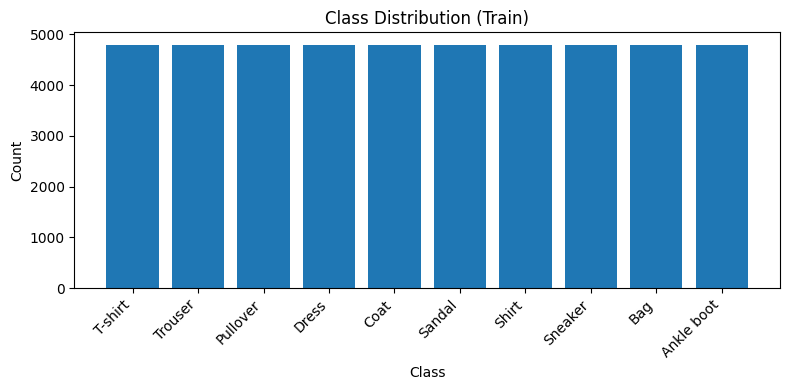

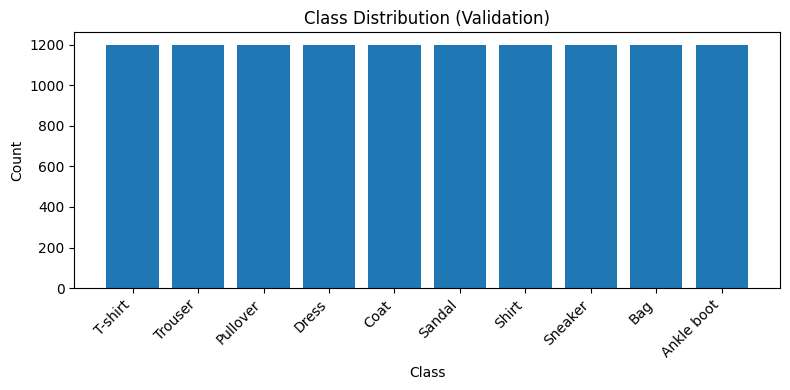

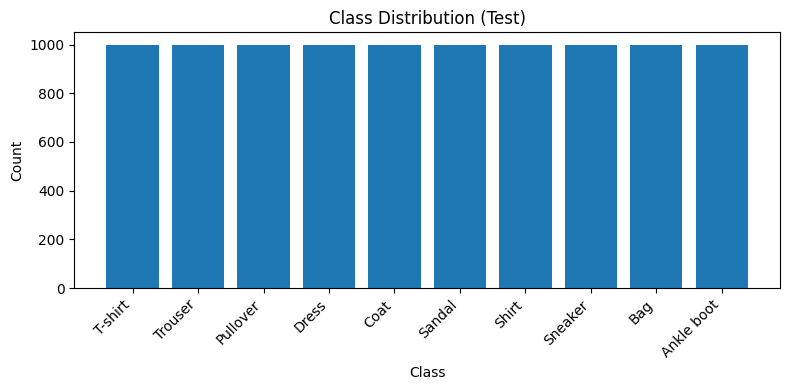

In [4]:
def plot_class_distribution(y, title):
    counts = np.bincount(y, minlength=10)
    plt.figure(figsize=(8,4))
    plt.bar(range(10), counts)
    plt.xticks(range(10), label_names, rotation=45, ha="right")
    plt.title(title); plt.xlabel("Class"); plt.ylabel("Count")
    plt.tight_layout(); plt.show()

plot_class_distribution(y_train, "Class Distribution (Train)")
plot_class_distribution(y_val,   "Class Distribution (Validation)")
plot_class_distribution(y_test,  "Class Distribution (Test)")


2. **Pixel Statistics**  
   We report global mean/std of raw pixels on the train set and per-class mean intensities, then briefly interpret.

In [5]:
# Global mean/std on raw pixels (train only)
global_mean = X_train.astype(np.float32).mean()
global_std  = X_train.astype(np.float32).std()
print(f"Global mean (train): {global_mean:.2f}")
print(f"Global std  (train): {global_std:.2f}")

# Per-class mean intensity (train)
per_class_means = []
for c in range(10):
    m = X_train[y_train==c].astype(np.float32).mean()
    per_class_means.append(m)

print("\nPer-class mean intensities (train):")
for name, m in zip(label_names, per_class_means):
    print(f"{name:<12}: {m:.2f}")


Global mean (train): 0.29
Global std  (train): 0.35

Per-class mean intensities (train):
T-shirt     : 0.32
Trouser     : 0.22
Pullover    : 0.38
Dress       : 0.26
Coat        : 0.38
Sandal      : 0.14
Shirt       : 0.33
Sneaker     : 0.17
Bag         : 0.35
Ankle boot  : 0.30


3. **Visualization**  
   At least one example image per class for a quick visual check.

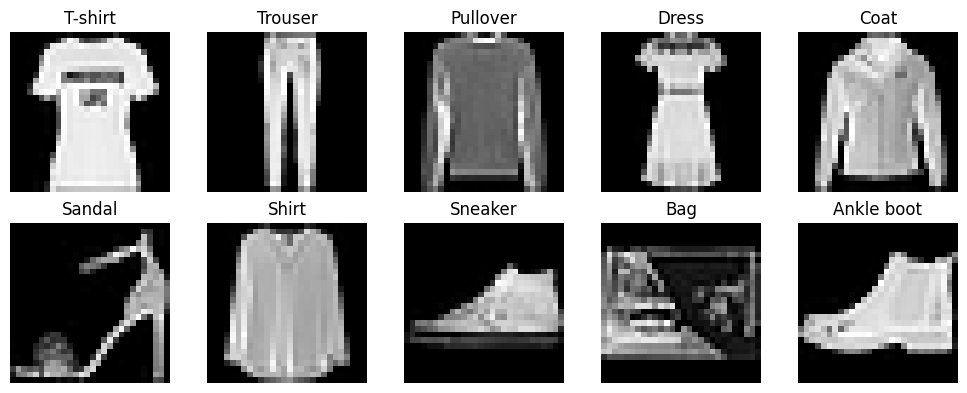

In [6]:
plt.figure(figsize=(10,4))
for c in range(10):
    idx = np.where(y_train==c)[0][0]
    plt.subplot(2,5,c+1)
    plt.imshow(X_train[idx], cmap="gray")
    plt.title(label_names[c]); plt.axis("off")
plt.tight_layout(); plt.show()


## Step 3 — Preprocessing

We prepare the data for scikit-learn:

1) **Flatten (2.3.2):** reshape images from `(28×28)` to a 2-D matrix `(n_samples, 784)` so distance-based models (k-NN) can operate on feature vectors.

2) **Standardize (2.3.1):** use `sklearn.preprocessing.StandardScaler` **fit on the train set only**, then transform val/test with the same parameters.  
   We print the mean/std **before vs. after** to verify near-zero mean and unit variance on the training features.


In [7]:
# 3.1 Flatten
# Keep raw (unscaled) pixels; convert to float32 for sklearn
X_train_flat = X_train.reshape(len(X_train), -1).astype(np.float32)
X_val_flat   = X_val.reshape(len(X_val), -1).astype(np.float32)
X_test_flat  = X_test.reshape(len(X_test), -1).astype(np.float32)

print("Shapes (flat):", X_train_flat.shape, X_val_flat.shape, X_test_flat.shape)

# Inspect raw statistics BEFORE scaling (on train only)
raw_mean = X_train_flat.mean()
raw_std  = X_train_flat.std()
print(f"Before scaling (train): mean={raw_mean:.2f}, std={raw_std:.2f}")

# 3.2 Standardize with StandardScaler
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler(with_mean=True, with_std=True)
X_train_scaled = scaler.fit_transform(X_train_flat)   # fit on TRAIN
X_val_scaled   = scaler.transform(X_val_flat)         # transform VAL
X_test_scaled  = scaler.transform(X_test_flat)        # transform TEST

# Verify statistics AFTER scaling (should be ~0 mean and ~1 std on TRAIN)
scaled_mean = X_train_scaled.mean()
scaled_std  = X_train_scaled.std()
print(f"After scaling  (train): mean={scaled_mean:.4f}, std={scaled_std:.4f}")


Shapes (flat): (48000, 784) (12000, 784) (10000, 784)
Before scaling (train): mean=0.29, std=0.35
After scaling  (train): mean=-0.0000, std=1.0000


## Step 4 — k-NN Classifier: Hyperparameter Tuning

We tune:
- **k ∈ {1, 3, 5, 7}**
- **distance metric ∈ {euclidean, manhattan}**

For each (metric, k) we train on the **scaled train set** and evaluate **validation accuracy**.
We then plot **validation accuracy vs k** for both metrics on the same figure and pick the best setting.


In [9]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import time

k_values = [1, 3, 5, 7]
metrics = ["euclidean", "manhattan"]

val_results = []  # (metric, k, val_acc, fit_time, pred_time)

for metric in metrics:
    for k in k_values:
        if metric == "euclidean":
            # Euclidean distance = Minkowski with p=2
            knn = KNeighborsClassifier(n_neighbors=k, metric="minkowski", p=2)
        else:
            knn = KNeighborsClassifier(n_neighbors=k, metric="manhattan")

        t0 = time.perf_counter()
        knn.fit(X_train_scaled, y_train)
        fit_time = time.perf_counter() - t0

        t1 = time.perf_counter()
        y_val_pred = knn.predict(X_val_scaled)
        pred_time = time.perf_counter() - t1

        acc = accuracy_score(y_val, y_val_pred)
        val_results.append((metric, k, acc, fit_time, pred_time))
        print(f"{metric:9s}  k={k}  |  val_acc={acc:.4f}  |  fit={fit_time:.3f}s  |  pred={pred_time:.3f}s")

# pick best by highest val acc (tie → smaller k)
best_metric, best_k, best_acc, _, _ = sorted(val_results, key=lambda t: (-t[2], t[1]))[0]
print("\nBEST:", f"metric={best_metric}, k={best_k}, val_acc={best_acc:.4f}")


euclidean  k=1  |  val_acc=0.8521  |  fit=0.035s  |  pred=7.821s
euclidean  k=3  |  val_acc=0.8553  |  fit=0.022s  |  pred=9.011s
euclidean  k=5  |  val_acc=0.8548  |  fit=0.019s  |  pred=9.079s
euclidean  k=7  |  val_acc=0.8562  |  fit=0.021s  |  pred=9.289s
manhattan  k=1  |  val_acc=0.8570  |  fit=0.023s  |  pred=138.189s
manhattan  k=3  |  val_acc=0.8631  |  fit=0.026s  |  pred=142.609s
manhattan  k=5  |  val_acc=0.8661  |  fit=0.021s  |  pred=139.628s
manhattan  k=7  |  val_acc=0.8643  |  fit=0.026s  |  pred=148.114s

BEST: metric=manhattan, k=5, val_acc=0.8661


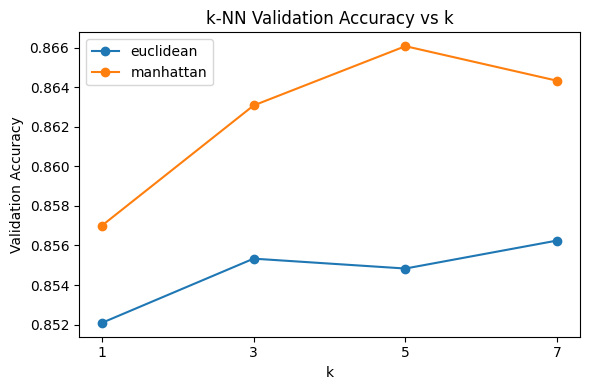

In [10]:
# collect accuracies per metric for plotting
acc_euclid   = [a for (m,k,a,_,_) in val_results if m == "euclidean"]
acc_manhattan= [a for (m,k,a,_,_) in val_results if m == "manhattan"]

plt.figure(figsize=(6,4))
plt.plot(k_values, acc_euclid, marker="o", label="euclidean")
plt.plot(k_values, acc_manhattan, marker="o", label="manhattan")
plt.xticks(k_values)
plt.xlabel("k")
plt.ylabel("Validation Accuracy")
plt.title("k-NN Validation Accuracy vs k")
plt.legend()
plt.tight_layout()
plt.show()


## Step 4 — Final Model

Using the best hyperparameters, we retrain k-NN on the **concatenated training + validation** sets and evaluate on the **held-out test set**. We report overall accuracy, macro precision/recall/F1, and a confusion matrix. We also record fit/predict times to discuss the “lazy learner” nature of k-NN.


Test Accuracy: 0.8613
Macro Precision: 0.8625  Macro Recall: 0.8613  Macro F1: 0.8609
Times — fit: 0.036s   predict: 138.396s


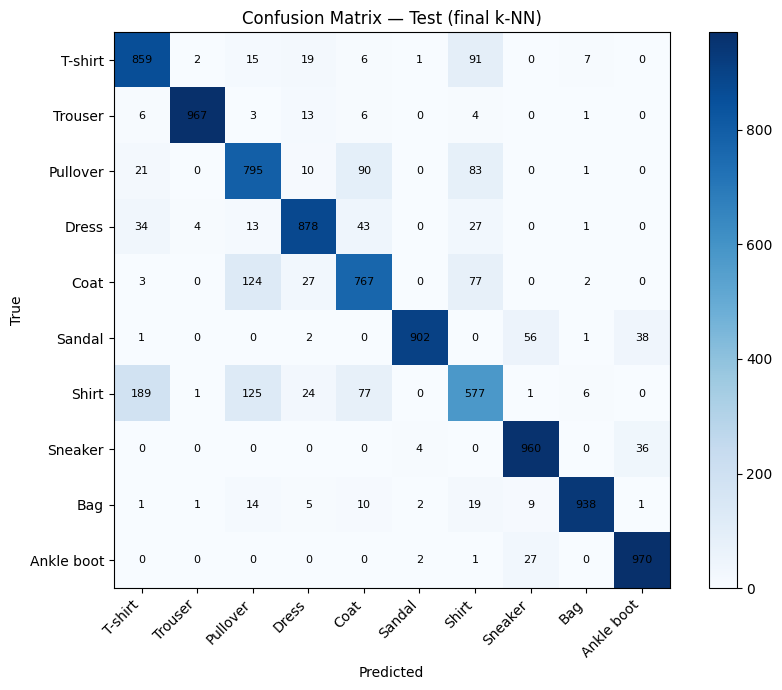

              precision    recall  f1-score   support

     T-shirt     0.7711    0.8590    0.8127      1000
     Trouser     0.9918    0.9670    0.9792      1000
    Pullover     0.7300    0.7950    0.7611      1000
       Dress     0.8978    0.8780    0.8878      1000
        Coat     0.7678    0.7670    0.7674      1000
      Sandal     0.9901    0.9020    0.9440      1000
       Shirt     0.6564    0.5770    0.6142      1000
     Sneaker     0.9117    0.9600    0.9352      1000
         Bag     0.9801    0.9380    0.9586      1000
  Ankle boot     0.9282    0.9700    0.9487      1000

    accuracy                         0.8613     10000
   macro avg     0.8625    0.8613    0.8609     10000
weighted avg     0.8625    0.8613    0.8609     10000



In [11]:
from time import perf_counter
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix

# Use your chosen hyperparams from tuning:
best_metric = "manhattan"   # change if your best differs
best_k = 5                   # change if your best differs

# 1) Concatenate train+val
X_trainval_scaled = np.vstack([X_train_scaled, X_val_scaled])
y_trainval = np.concatenate([y_train, y_val])

# 2) Build model with best hyperparams
if best_metric == "euclidean":
    final_knn = KNeighborsClassifier(n_neighbors=best_k, metric="minkowski", p=2, n_jobs=-1)
else:
    final_knn = KNeighborsClassifier(n_neighbors=best_k, metric="manhattan", n_jobs=-1)

# 3) Timing: fit + predict
t0 = perf_counter()
final_knn.fit(X_trainval_scaled, y_trainval)
fit_time = perf_counter() - t0

t1 = perf_counter()
y_test_pred = final_knn.predict(X_test_scaled)
pred_time = perf_counter() - t1

# 4) Metrics
test_acc = accuracy_score(y_test, y_test_pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_test_pred, average="macro", zero_division=0)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Macro Precision: {prec:.4f}  Macro Recall: {rec:.4f}  Macro F1: {f1:.4f}")
print(f"Times — fit: {fit_time:.3f}s   predict: {pred_time:.3f}s")

# 5) Confusion matrix (matplotlib-only)
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(9,7))
plt.imshow(cm, cmap="Blues")
plt.colorbar()
plt.xticks(range(10), label_names, rotation=45, ha="right")
plt.yticks(range(10), label_names)
plt.xlabel("Predicted"); plt.ylabel("True")
plt.title("Confusion Matrix — Test (final k-NN)")
# annotate
for i in range(10):
    for j in range(10):
        plt.text(j, i, cm[i, j], ha="center", va="center", fontsize=8)
plt.tight_layout(); plt.show()

# Optional full classification report
print(classification_report(y_test, y_test_pred, target_names=label_names, digits=4))


## Step 5 — Error Analysis

We identify the **top-3 most confused class pairs** from the off-diagonal counts of the test confusion matrix. For each pair, we display up to **5 randomly chosen misclassified examples** (true label → predicted label), and comment on plausible reasons (visual similarity, silhouette, texture/patterns).


Top-3 confused pairs (count, true, pred): [(np.int64(189), np.str_('Shirt'), np.str_('T-shirt')), (np.int64(125), np.str_('Shirt'), np.str_('Pullover')), (np.int64(124), np.str_('Coat'), np.str_('Pullover'))]

Pair: true=Shirt  predicted=T-shirt  (showing 5 examples)


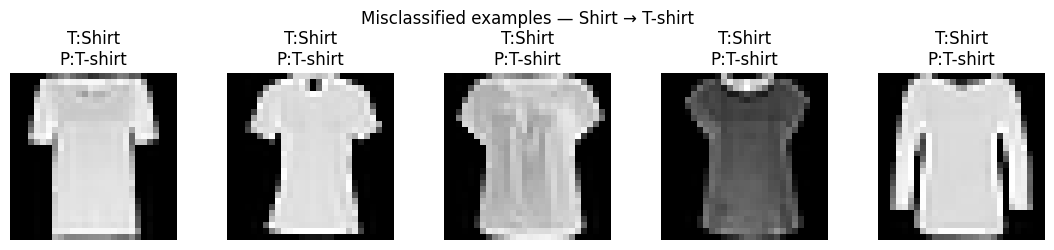


Pair: true=Shirt  predicted=Pullover  (showing 5 examples)


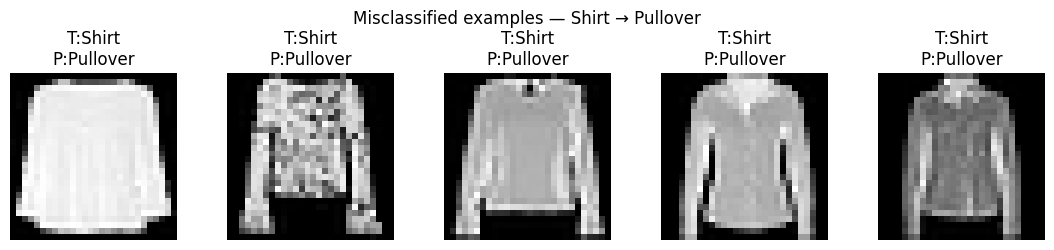


Pair: true=Coat  predicted=Pullover  (showing 5 examples)


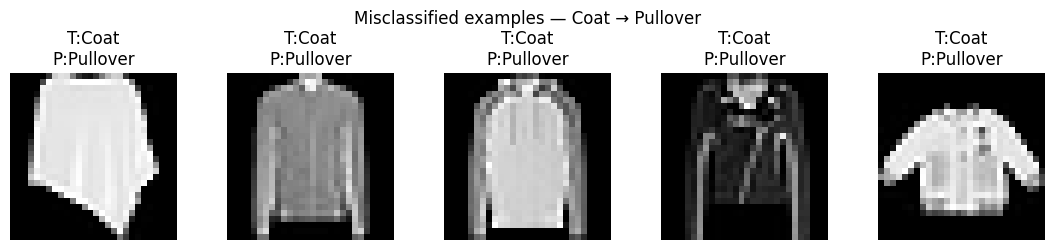

In [12]:
# Find top-3 confused pairs (largest off-diagonal counts)
cm_off = cm.copy().astype(np.int64)
np.fill_diagonal(cm_off, 0)
pairs = []
for i in range(10):
    for j in range(10):
        if i != j and cm_off[i, j] > 0:
            pairs.append((cm_off[i, j], i, j))
pairs.sort(reverse=True)  # biggest confusions first
top3 = pairs[:3]
print("Top-3 confused pairs (count, true, pred):", [(c, label_names[i], label_names[j]) for c,i,j in top3])

# Indices of misclassified samples per pair
y_test = np.array(y_test)
mis_idx = np.where(y_test != y_test_pred)[0]

import random
rng = np.random.default_rng(42)

for _, true_c, pred_c in top3:
    idx_pair = [idx for idx in mis_idx if (y_test[idx] == true_c and y_test_pred[idx] == pred_c)]
    show = rng.choice(idx_pair, size=min(5, len(idx_pair)), replace=False) if idx_pair else []
    print(f"\nPair: true={label_names[true_c]}  predicted={label_names[pred_c]}  (showing {len(show)} examples)")

    if len(show) == 0:
        print("No examples to show.")
        continue

    # Plot up to 5 examples
    cols = len(show)
    plt.figure(figsize=(2.2*cols, 2.5))
    for k, idx in enumerate(show):
        plt.subplot(1, cols, k+1)
        plt.imshow(X_test[idx], cmap="gray")
        plt.title(f"T:{label_names[true_c]}\nP:{label_names[pred_c]}")
        plt.axis("off")
    plt.suptitle(f"Misclassified examples — {label_names[true_c]} → {label_names[pred_c]}")
    plt.tight_layout(); plt.show()


This happens because they shared similar silhouettes and textures.